In [9]:
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

import random

# Paths
model_path = 'models/bvlc_googlenet/'
net_fn = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

# Functions
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']

def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

def make_white_noise_image(width, height):
    """Make a white noise image of the given width and height"""
    
    img = PIL.Image.new("RGBA", (width, height), 'white')
    noise_vals = map(lambda x: (
            int(random.random() * 256),
            int(random.random() * 256),
            int(random.random() * 256)
        ), [0] * width * height)
    img.putdata(noise_vals)
    
    return img

In [4]:
# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
proto_file = 'project_tmp.prototxt'

model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open(proto_file, 'w').write(str(model))

net = caffe.Classifier(proto_file, param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

In [5]:
def objective_L2(dst):
    dst.diff[:] = dst.data 

def make_step(net, step_size=1.5, end='inception_4c/output', 
              jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    objective(dst)  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)

In [6]:
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, 
              end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

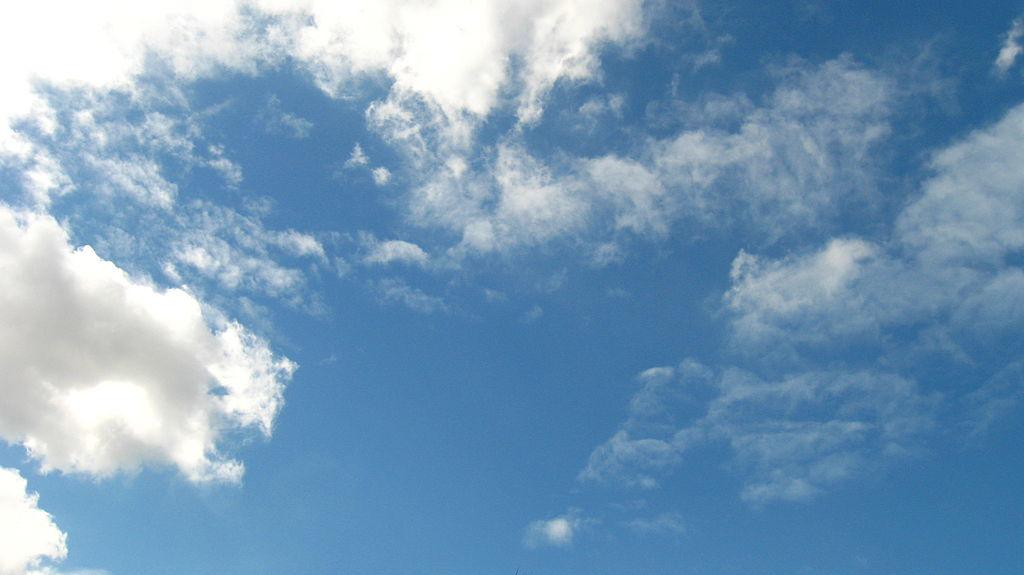

In [7]:
img = np.float32(PIL.Image.open('sky1024px.jpg'))
# img = np.float32(PIL.Image.open('white_noise.jpeg'))
showarray(img)

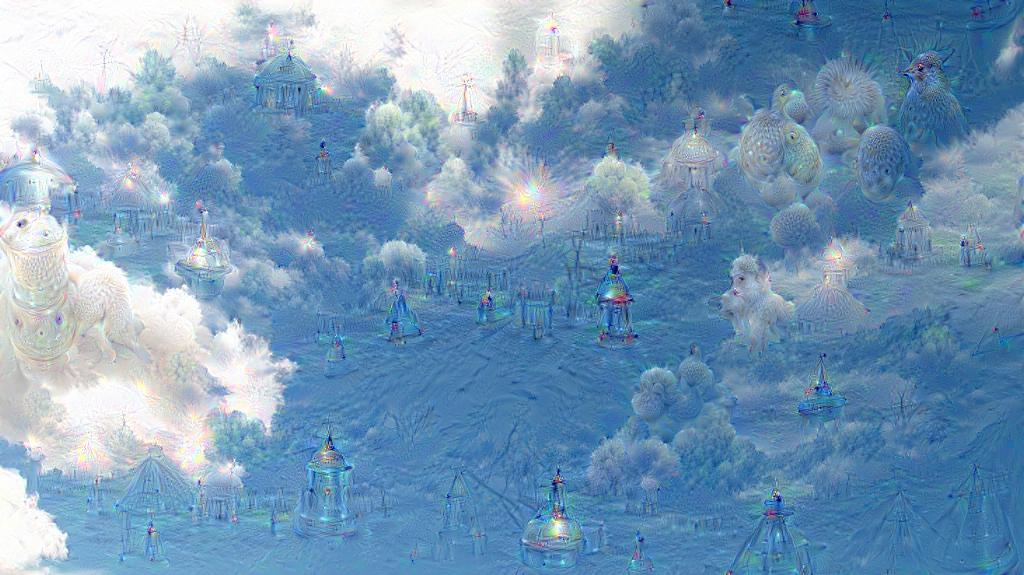

3 9 inception_4c/output (575, 1024, 3)


In [8]:
_=deepdream(net, img)

In [ ]:
_=deepdream(net, img, end='inception_3b/5x5_reduce')

In [ ]:
_=deepdream(net, img, end='inception_5a/output', octave_n=2, iter_n=10)

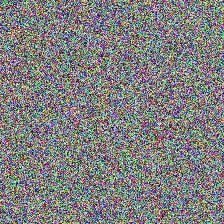

In [30]:
noise_img = make_white_noise_image(224, 224)
showarray(noise_img)
noise_img.save('white_noise.jpeg')

# Save image to memory file
f = StringIO()
noise_img.save(f, 'jpeg')

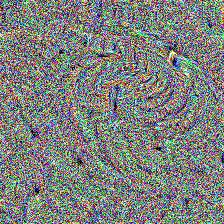

3 9 inception_5a/output (224, 224, 3)


In [31]:
_=deepdream(net, np.float32(PIL.Image.open(f)), octave_n=4, iter_n=10, end='inception_5a/output')

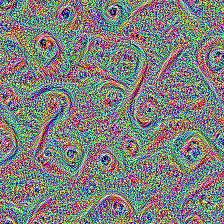

3 9 inception_3a/output (224, 224, 3)


In [32]:
_=deepdream(net, np.float32(PIL.Image.open(f)), octave_n=4, iter_n=10, end='inception_3a/output')

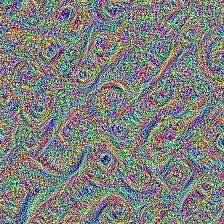

3 9 inception_3a/3x3_reduce (224, 224, 3)


In [33]:
_=deepdream(net, np.float32(PIL.Image.open(f)), octave_n=4, iter_n=10, end='inception_3a/3x3_reduce')

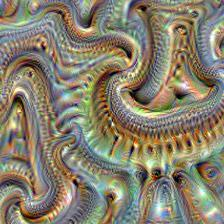

3 9 inception_4c/output (224, 224, 3)


In [34]:
frame = img
frame_i = 0

h, w = frame.shape[:2]
s = 0.05 # scale coefficient
for i in xrange(10):
    frame = deepdream(net, frame)
    #PIL.Image.fromarray(np.uint8(frame)).save("frames_white_noise/%04d.jpg"%frame_i)
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    frame_i += 1